In [1]:
import torch
from torch.utils.data import DataLoader
import albumentations as A
from datasets import GTA5, CityScapes
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from models.bisenet.build_bisenet import BiSeNet
from training import train
from model_evaluation import save_results
from visualization import  plot_loss, plot_mIoU, plot_IoU
from config import BATCH_SIZE, NC, NUM_WORKERS, CITYSCAPE_SIZE, GTA5_SIZE, EPOCHS, CITYSCAPES_MEAN, CITYSCAPES_STD, GTA5_MEAN, GTA5_STD
torch.cuda.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:

transforms = A.Compose([
    A.Resize(CITYSCAPE_SIZE[0], CITYSCAPE_SIZE[1]),
])
transforms_GTA5 = A.Compose([
    A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
])

cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transforms)
cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transforms)
GTA5_dataset = GTA5('./GTA5', transform=transforms_GTA5)

cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# cityscapes_mean, city_scapes_std = calculate_mean_std(cityscapes_train_dataloader)
# GTA5_mean, GTA5_std = calculate_mean_std(GTA5_dataloader)

len(cityscapes_train_dataloader)

393

## 2.1 DeepLabV2

In [3]:

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
init_lr = 2.5e-4
model_deeplab = get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='./models/deeplab_resnet_pretrained_imagenet.pth').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_deeplab = torch.nn.DataParallel(model_deeplab).to(device)
optimizer_deeplab = torch.optim.Adam(model_deeplab.parameters(), lr=init_lr)

deeplab_result = train(model = model_deeplab,
                       optimizer = optimizer_deeplab,
                       loss_fn = loss_fn, 
                       train_dataloader = cityscapes_train_dataloader,
                       validation_dataloader = cityscapes_test_dataloader, 
                       epochs = EPOCHS,
                       device = device,
                       model_name = "deeplab",
                       class_number= NC)

Deeplab pretraining loading...


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
save_results(model_deeplab, deeplab_result, "deeplab_performance_metrics_2_1", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=10)
plot_loss(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")
plot_mIoU(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")
plot_IoU(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")

torch.save(model_deeplab.state_dict(), "./checkpoints/deeplab_model_2_1.pth")

## 2.2 BiseNet


In [3]:
init_lr = 7.5e-4
model_bisenet = BiSeNet(NC, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet = torch.nn.DataParallel(model_bisenet).to(device)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer_bisenet = torch.optim.Adam(model_bisenet.parameters(), lr=init_lr)

bisenet_result_2_2 = train(model = model_bisenet,
                           optimizer = optimizer_bisenet,
                           loss_fn = loss_fn, 
                           train_dataloader = cityscapes_train_dataloader,
                           validation_dataloader = cityscapes_test_dataloader, 
                           epochs = EPOCHS,
                           device = device,
                           model_name = "bisenet",
                           class_number= NC)



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.9750952036629499, Validation Loss: 0.4558972148895264
Train mIoU: 0.2717077295375971, Validation mIoU: 0.3011972049835455
Epoch: 1
Train Loss: 1.1110991817394287, Validation Loss: 0.3863005157709122
Train mIoU: 0.35196699583501345, Validation mIoU: 0.32360695437390014
Epoch: 2
Train Loss: 0.9404229853899424, Validation Loss: 0.36963454616069796
Train mIoU: 0.37879533866705173, Validation mIoU: 0.33546137685377825
Epoch: 3
Train Loss: 0.8269328504573298, Validation Loss: 0.32507904267311094
Train mIoU: 0.41221506117536194, Validation mIoU: 0.3752642527620047
Epoch: 4
Train Loss: 0.7249117091715184, Validation Loss: 0.30682606196403506
Train mIoU: 0.4393958313232935, Validation mIoU: 0.40055165456871333
Epoch: 5
Train Loss: 0.6607401131370292, Validation Loss: 0.292643025636673
Train mIoU: 0.4580289647666951, Validation mIoU: 0.41174994059228304
Epoch: 6
Train Loss: 0.5833925818668977, Validation Loss: 0.3141487882137299
Train mIoU: 0.4811140713446444, Validation m

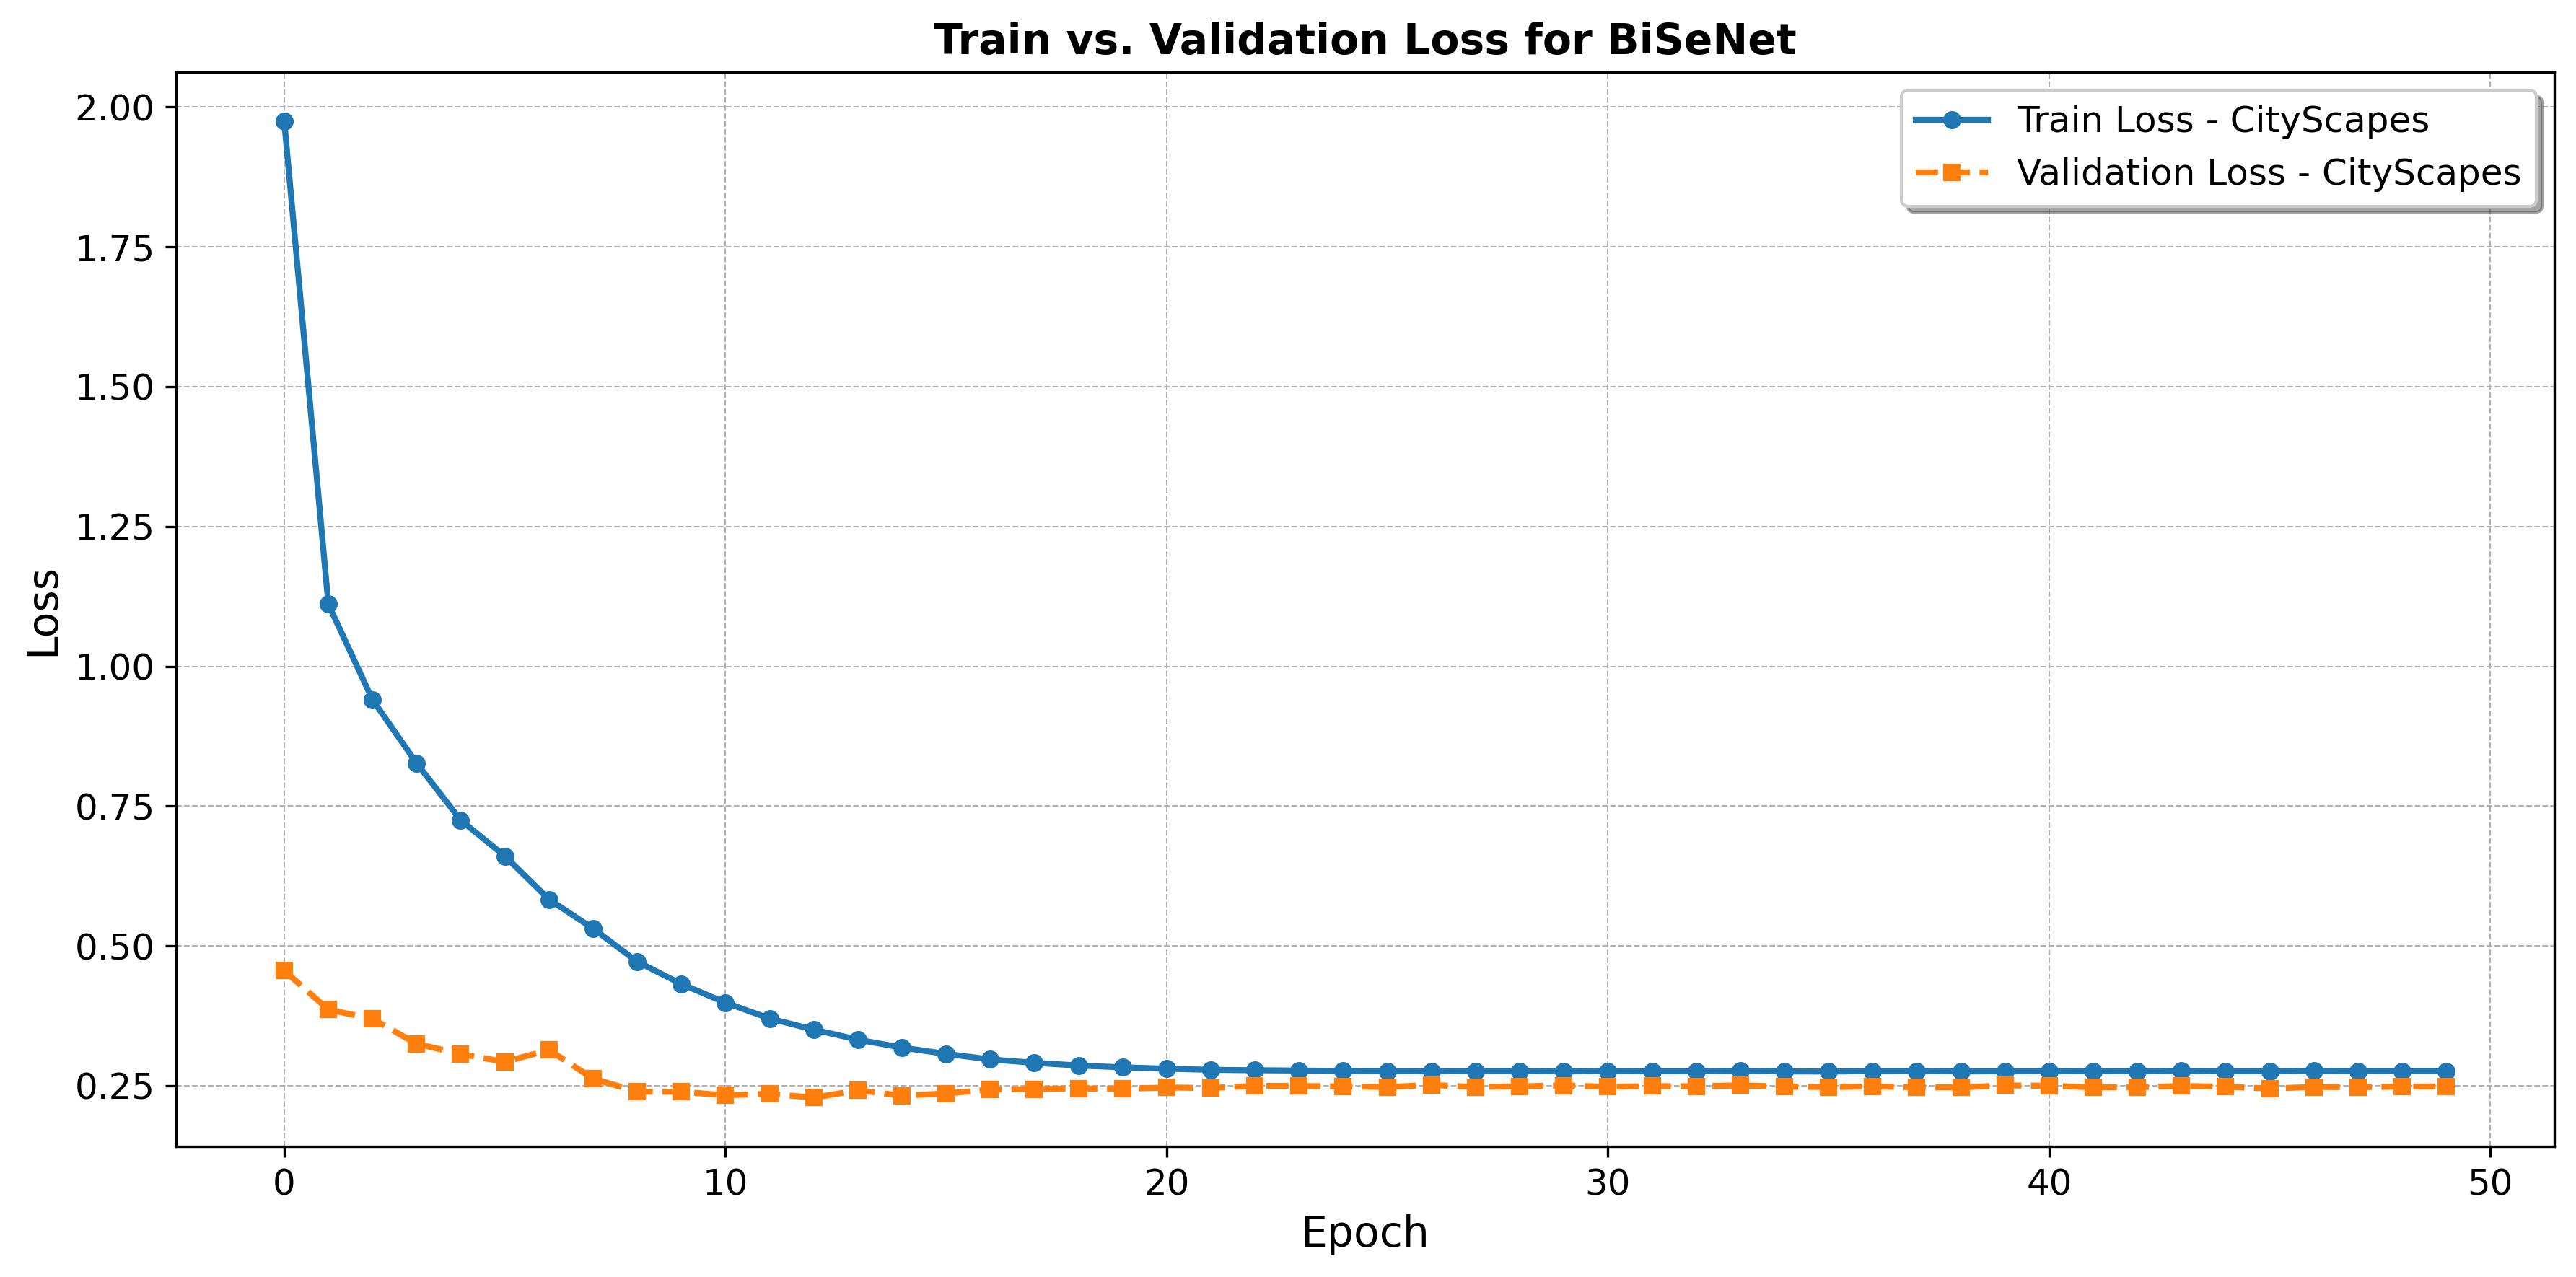

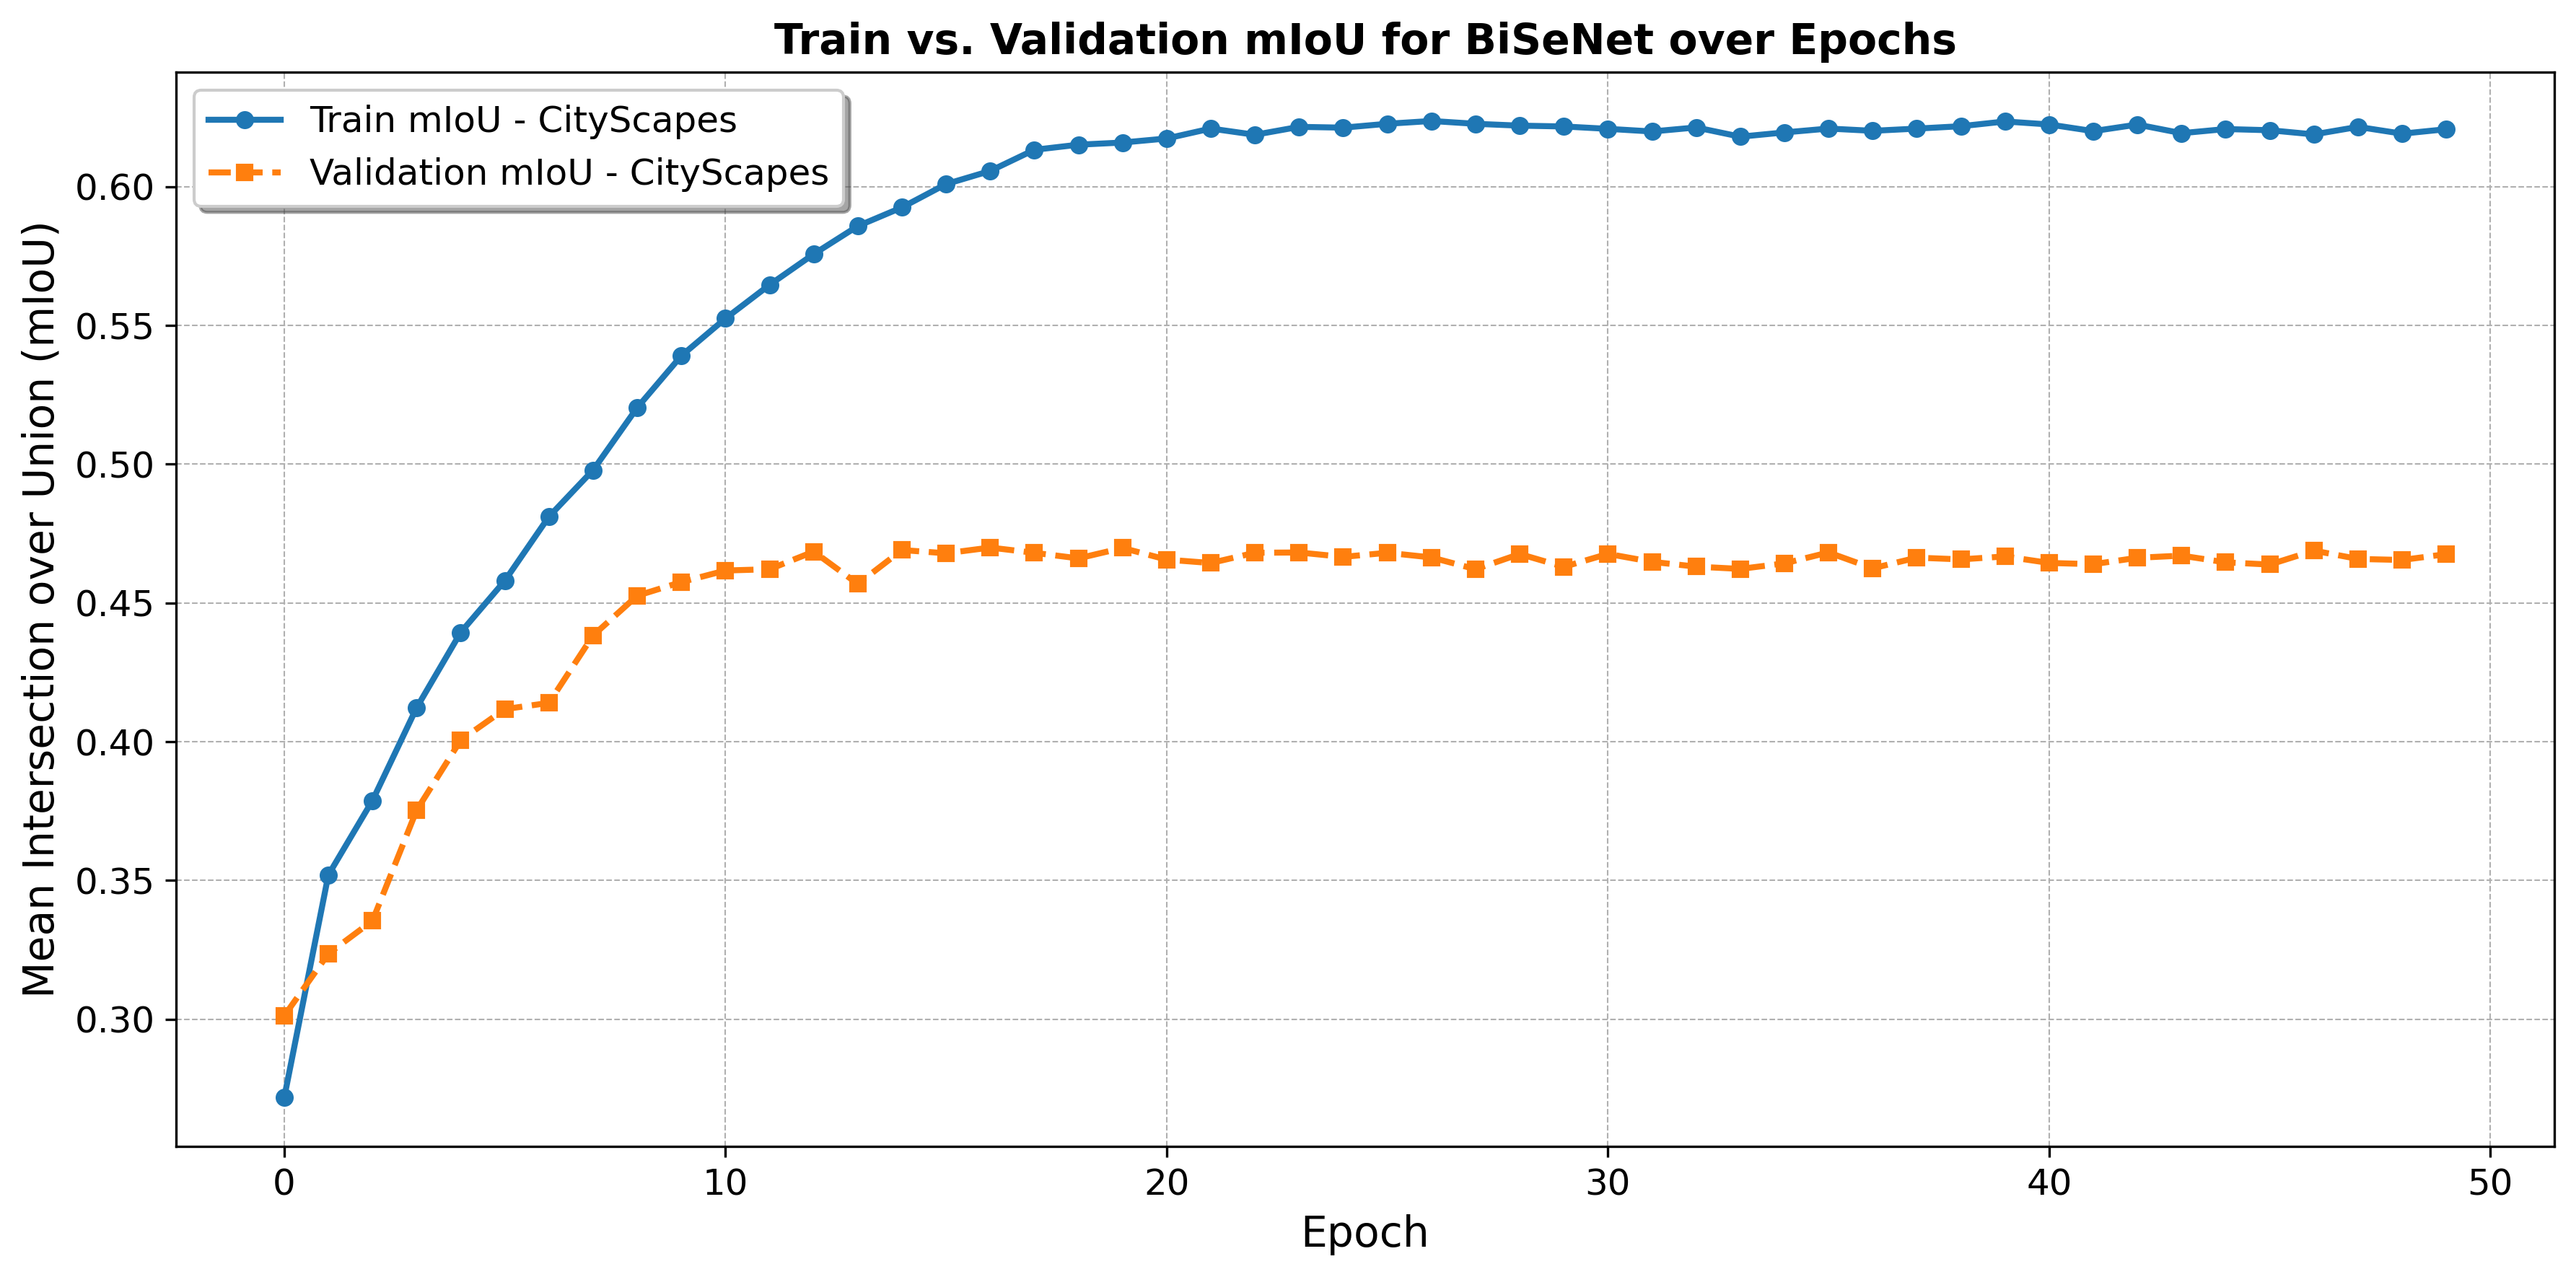

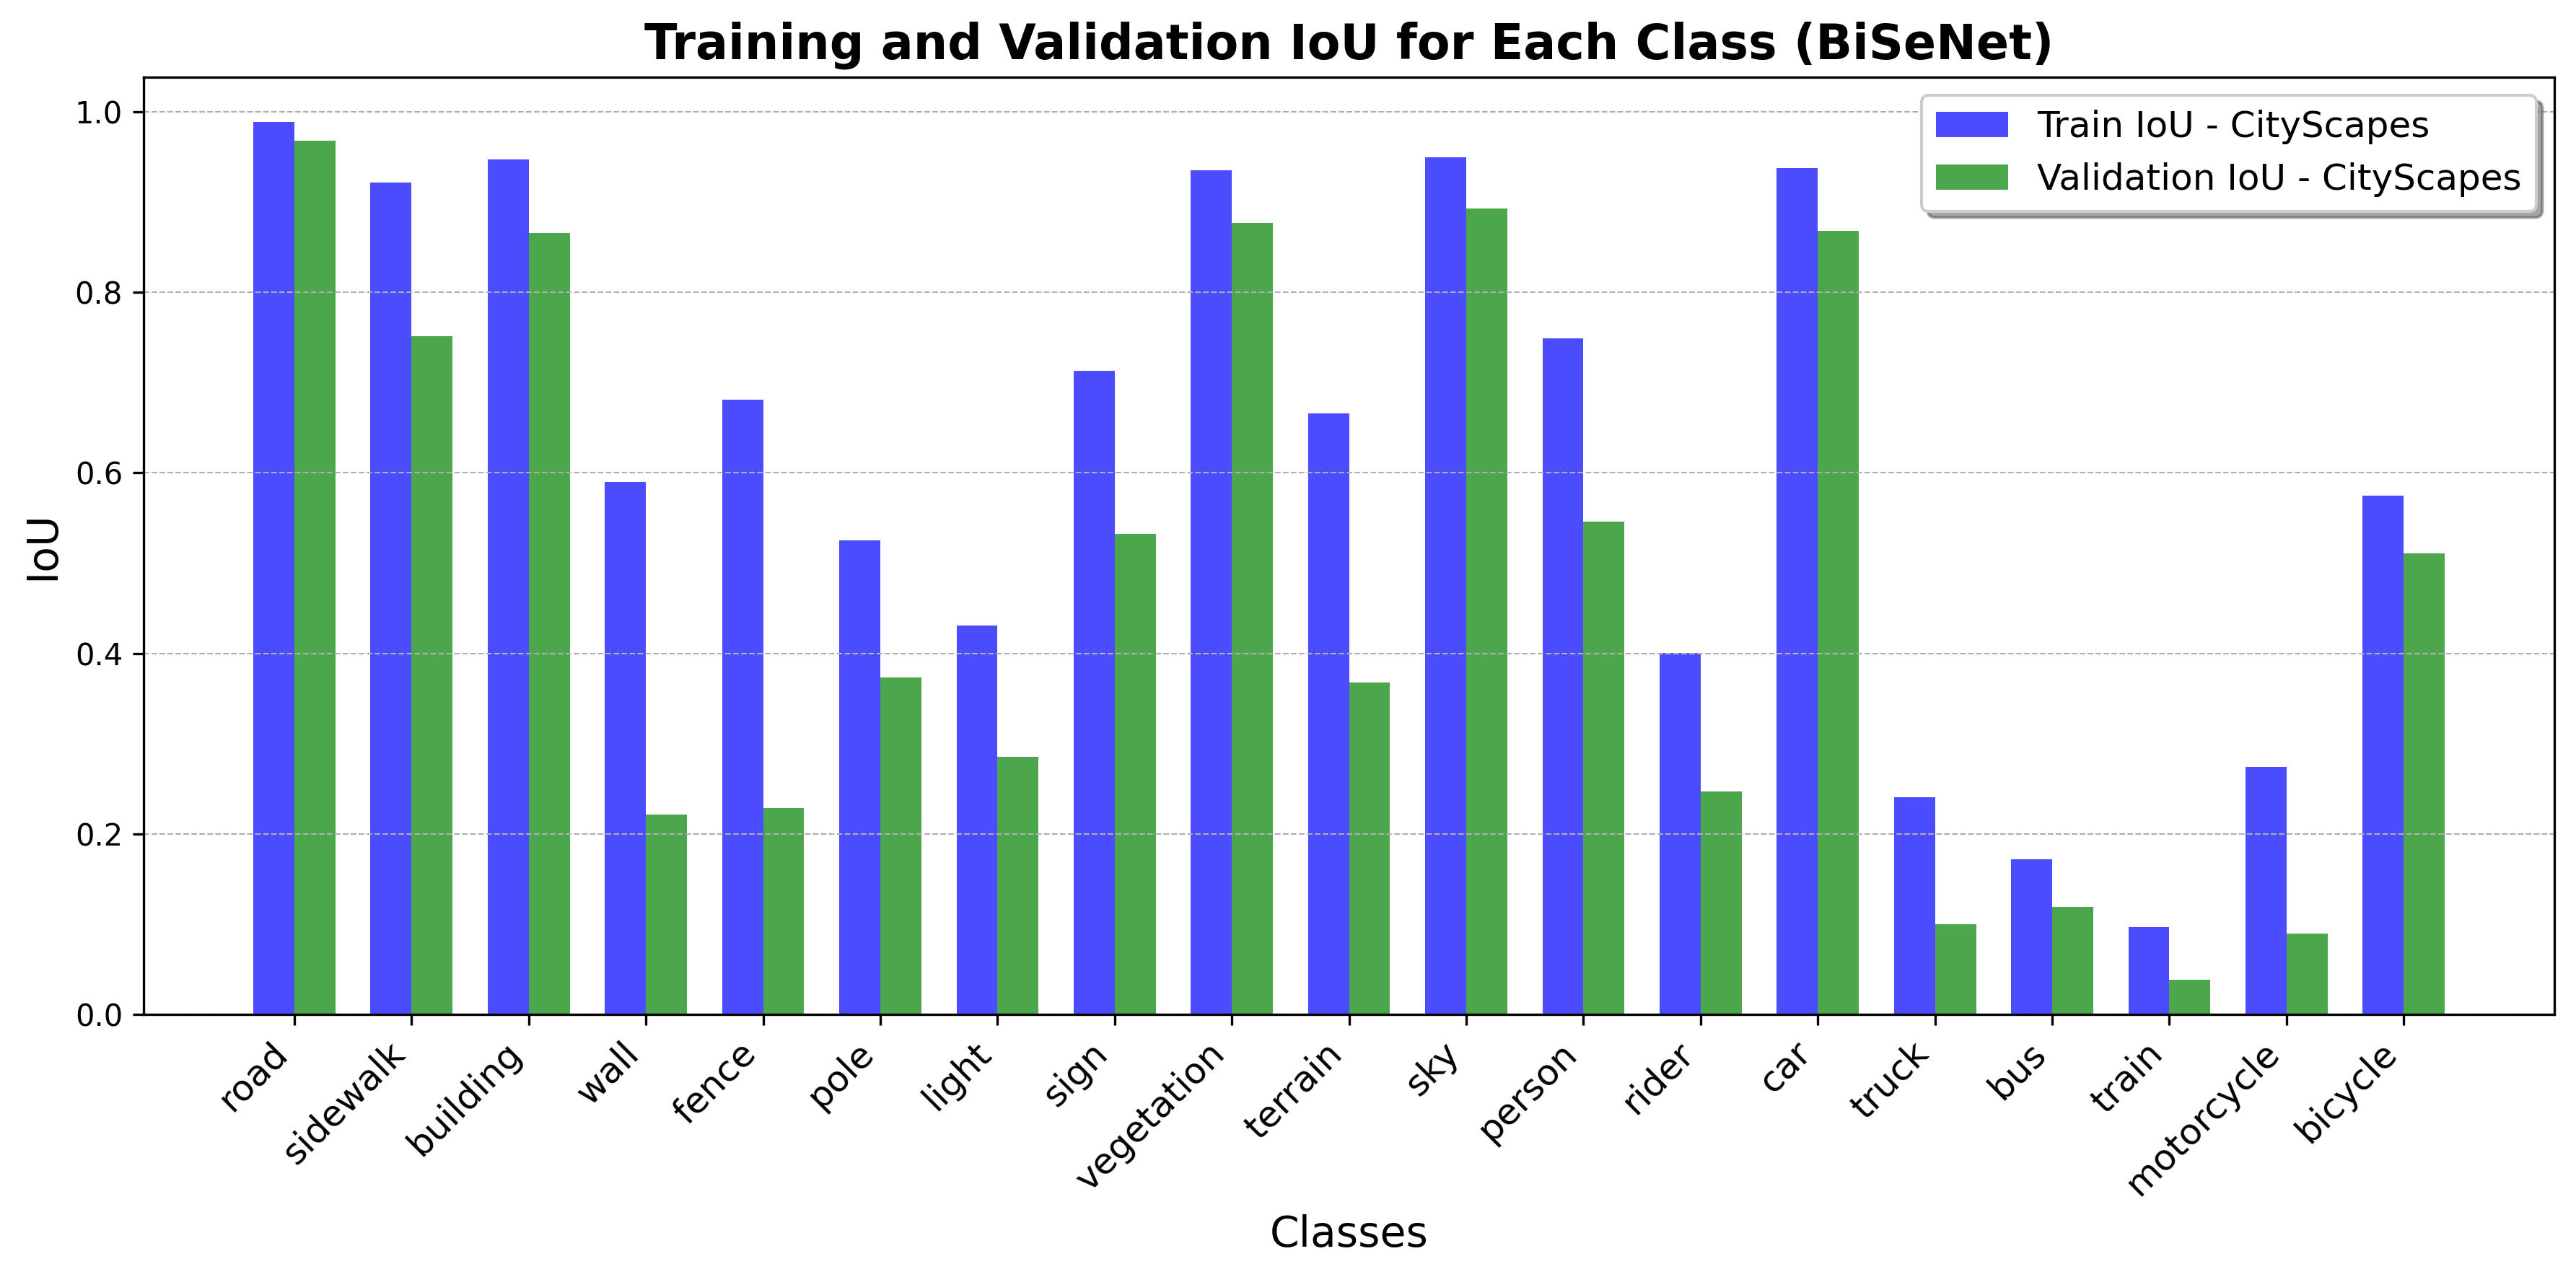

In [9]:

import importlib
import model_evaluation
importlib.reload(model_evaluation)
from model_evaluation import save_results


save_results(model_bisenet, bisenet_result_2_2, "bisenet_performance_metrics_2_2", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=1000)
plot_loss(bisenet_result_2_2, "BiSeNet", "step2_2", "CityScapes", "CityScapes")
plot_mIoU(bisenet_result_2_2, "BiSeNet", "step2_2", "CityScapes", "CityScapes")
plot_IoU(bisenet_result_2_2, "BiSeNet", "step2_2", "CityScapes", "CityScapes")
torch.save(model_bisenet.state_dict(), "./checkpoints/bisenet_model_2_2.pth")

## 3.1 Bisenet

In [10]:
model_bisenet_3_1 = BiSeNet(19, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_3_1 = torch.nn.DataParallel(model_bisenet_3_1).to(device)
init_lr = 7.5e-4
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer_bisenet_3_1 = torch.optim.Adam(model_bisenet_3_1.parameters(), lr=init_lr)
bisenet_result_3_1 = train(model=model_bisenet_3_1,
                           optimizer=optimizer_bisenet_3_1,
                           loss_fn=loss_fn,
                           train_dataloader=GTA5_dataloader,
                           validation_dataloader=cityscapes_test_dataloader,
                           epochs=EPOCHS,
                           device=device,
                           model_name="bisenet",
                           class_number=NC)



  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
save_results(model_bisenet_3_1, bisenet_result_3_1, "bisenet_performance_metrics_3_1", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=1000)
plot_loss(bisenet_result_3_1, "BiSeNet", "step3_1", "GTA5", "CityScapes")
plot_mIoU(bisenet_result_3_1, "BiSeNet", "step3_1", "GTA5", "CityScapes")
plot_IoU(bisenet_result_3_1, "BiSeNet", "step3_1", "GTA5", "CityScapes")
torch.save(model_bisenet_3_1.state_dict(), "./checkpoints/bisenet_model_3_1.pth")

## 3.2 Bisenet with augmentation



In [ ]:

augmentations = {
    'transform1': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]),
    'transform2': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HueSaturationValue(p=0.5),
        A.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1), p=0.5),
    ]),
    'transform3': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1), p=0.5),
        A.GaussNoise(p=0.5),
    ]),
    'transform4': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]),
    'transform5': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1), p=0.5),
        A.GaussNoise(p=0.5),
    ]),
    'transform6': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
    ])
}
best_score = 0
best_transform = ''

# Evaluate each augmentation strategy
for transform_name, transform_pipeline in augmentations.items():
    # Prepare datasets with the current transformation
    cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transform_pipeline)
    cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transform_pipeline)
    GTA5_dataset = GTA5('./GTA5', transform=transform_pipeline)

    # Create dataloaders
    cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize model and optimizer
    model_bisenet_3_2 = BiSeNet(19, 'resnet18').to(device)
    if device == 'cuda' and torch.cuda.device_count() > 1:
        model_bisenet_3_2 = torch.nn.DataParallel(model_bisenet_3_2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.Adam(model_bisenet_3_2.parameters(), lr=2.5e-4)

    # Train the model
    bisenet_result3_2 = train(model=model_bisenet_3_2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              train_dataloader=GTA5_dataloader,
                              validation_dataloader=cityscapes_test_dataloader,
                              epochs=EPOCHS,
                              device=device,
                              model_name="bisenet",
                              class_number=NC)
    
    # Save and plot results
    save_results(model_bisenet_3_2, bisenet_result3_2, f"bisenet_performance_metrics_3_2_{transform_name}", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=10)
    plot_loss(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    plot_mIoU(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    plot_IoU(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    
    # Save model checkpoint
    torch.save(model_bisenet_3_2.state_dict(), f"./checkpoints/bisenet_model_3_2_{transform_name}.pth")
    
    # Update best performing transformation
    if best_score < bisenet_result3_2[3][-1]:
        best_score = bisenet_result3_2[3][-1]
        best_transform = transform_name

best_transform


# 4.1 FDA

In [ ]:
GTA5_dataset = GTA5('./GTA5', transform=transforms_GTA5, FDA = 0.09)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
model_bisenet_4_1_FDA = BiSeNet(19, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_4_1_FDA = torch.nn.DataParallel(model_bisenet_4_1_FDA).to(device)
init_lr = 2.5e-4 #0.0001
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model_bisenet_4_1_FDA.parameters(), lr=init_lr)

bisenet_result4_1_FDA = train(model = model_bisenet_4_1_FDA,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              train_dataloader = GTA5_dataloader,
                              validation_dataloader = cityscapes_test_dataloader,
                              epochs = EPOCHS,
                              device = device,
                              model_name = "bisenet",
                              class_number= NC)

    
save_results(model_bisenet_4_1_FDA, bisenet_result4_1_FDA, "bisenet_performance_metrics_4_1_FDA", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=10)
plot_loss(bisenet_result4_1_FDA, "BiSeNet", "step4_1_FDA", "GTA5", "CityScapes")
plot_mIoU(bisenet_result4_1_FDA, "BiSeNet", "step4_1_FDA", "GTA5", "CityScapes")
plot_IoU(bisenet_result4_1_FDA, "BiSeNet", "step4_1_FDA", "GTA5", "CityScapes")
torch.save(model_bisenet_4_1_FDA.state_dict(), f"./checkpoints/bisenet_model_4_1_FDA.pth")


# 4.2 DACS

1- In the paper they say that they are using pretrained model. but in pseudocode they say that they are initializing the model with random parameters.


In [ ]:
# GTA5_dataset = GTA5('./GTA5', transform=augmentations[best], FDA = 0.09)

sigma = 150 # 175 for gta5 size, 100 for cityscapes size
# GTA5_dataset = GTA5('./GTA5', transform=augmentations[best_transform], FDA = 0.09)

# GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
model_bisenet_4_2_DACS = BiSeNet(NC, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_4_2_DACS = torch.nn.DataParallel(model_bisenet_4_2_DACS).to(device)
init_lr = 2.5e-4 #0.0001
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model_bisenet_4_2_DACS.parameters(), lr=init_lr)

bisenet_result4_2_DACS = train(model = model_bisenet_4_2_DACS,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               train_dataloader= GTA5_dataloader,
                               validation_dataloader=cityscapes_test_dataloader,
                               target_dataloader=cityscapes_train_dataloader,
                               epochs=EPOCHS,
                               device = device,
                               model_name='bisenet',
                               )
save_results(model_bisenet_4_2_DACS, bisenet_result4_2_DACS, "bisenet_performance_metrics_4_2_DACS", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=10)
plot_loss(bisenet_result4_2_DACS, "BiSeNet", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")
plot_mIoU(bisenet_result4_2_DACS, "BiSeNet", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")
plot_IoU(bisenet_result4_2_DACS, "BiSeNet", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")

torch.save(model_bisenet_4_2_DACS.state_dict(), "./checkpoints/bisenet_model_4_2_DACS.pth")
